In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim
import torch.nn.functional as F
from abc import abstractmethod
from collections import defaultdict
from functools import lru_cache
from itertools import count
from typing import List, Dict
from typing import Tuple, Any
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from torch.nn import MSELoss, LSTM, GRU, RNN, L1Loss
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from learn2learn.data import InfiniteIterator
from torch.utils.data import DataLoader, RandomSampler

In [2]:
from logger import init_logging
from base_module import MModule
from data import MDataset, Graph, load_graphs
from importlib import reload
from config import Config
import config
from data import MDataset, Graph, GraphNode, load_graphs, save_dataset_pkl, load_dataset_pkl, save_scalers_pkl, load_scalers_pkl
import data
from base_module import MModule, pad_np_vectors
import base_module
from executor import meta_train, nested_detach, grid_search_loop
import executor
from objects import ModelType
import objects
from metric import MetricUtil
import metric
from logger import init_logging, logging
import logger
import gcn
from gcn import GCNLayer
import transformer
from transformer import TransformerModel
reload(config)
reload(data)
reload(base_module)
reload(executor)
reload(objects)
reload(metric)
reload(logger)
reload(gcn)
reload(transformer)
init_logging()

datasets_path: /root/guohao/repos/DLT-perf-model/datasets
configs_path: /root/guohao/repos/DLT-perf-model/notebooks/configs
datasets_path: /root/guohao/repos/DLT-perf-model/datasets
configs_path: /root/guohao/repos/DLT-perf-model/notebooks/configs


In [3]:
normalizer_cls = StandardScaler  # MinMaxScaler
dummy = False
train_support_maxrow = 500_000
train_query_maxrow = 100_000
eval_support_maxrow = 300_000  # adaption大小可以收缩
eval_query_maxrow = 200_000  # 测试集大小应该和不用元学习一致
model_type = ModelType.LSTM

In [4]:
train_configs = {
    ModelType.LSTM.name: Config.from_dict({
        "model": "LSTM",
        "dataset_environment_str": 'T4_CPUALL',
        "meta_dataset_environment_strs": ['P4_CPUALL', 'P4_CPU100'],
        "dataset_subgraph_node_size": 12,
        "dataset_subgraph_step": 3,
        "all_seed": 42,
        "dataset_params": {
            "duration_summed": False,
        },
        "model_params": {
            "num_layers": 4,
            "bidirectional": True
        },
        "dataset_dummy": False,
        "batch_size": 128,
        "eval_steps": 10,
        "learning_rate": 0.001,
        "epochs": 100,
        "optimizer": "Adam",
        "meta_configs": {
            "learning_rate": 0.1,  # LSTM learning rate
            "meta_learning_rate": 0.003,
            "meta_train_steps": 100,  # num iterations
            "meta_task_per_step": 16,  # meta batch_size
            "meta_fast_adaption_step": 1,  # adapt steps
            "meta_shots": 10,  # num of samples
            "meta_dataset_train_environment_strs": ['T4_CPUALL', 'RTX2080Ti_CPUALL', 'RTX3080Ti_CPUALL', 'T4_CPU100', 'RTX2080Ti_CPU100'],
            "meta_dataset_eval_environment_strs": ['P4_CPU100', 'P4_CPUALL'],
        },
    }),
}

conf: Config = train_configs[model_type.name]

In [5]:
def subgraph_features(graph: Graph, subgraph_node_size: int = 10, step: int = 5, dataset_params: Dict = {}) -> \
        Tuple[List[Dict], List[Dict]]:
    subgraphs, _ = graph.subgraphs(
        subgraph_node_size=subgraph_node_size, step=step)
    X, Y = list(), list()

    def subgraph_feature(nodes: List[GraphNode]):
        feature_matrix = list()
        for node in nodes:
            feature = node.op.to_feature_array(
                mode=dataset_params.get("mode", "complex"))
            feature = np.array(feature)
            feature_matrix.append(feature)

        feature_matrix = pad_np_vectors(feature_matrix)
        feature_matrix = np.array(feature_matrix)

        adj_matrix = [
            [0.] * len(nodes) for _ in range(len(nodes))
        ]
        for curr_idx, node in enumerate(nodes):
            if curr_idx + 1 < len(nodes):
                adj_matrix[curr_idx][curr_idx+1] = 1.

        adj_matrix = np.array(adj_matrix)
        # x
        feature = {
            "x_graph_id": graph.ID,
            "x_node_ids": "|".join([str(node.node_id) for node in nodes]),
            "x_subgraph_feature": feature_matrix,
            "x_adj_matrix": adj_matrix
        }

        # y
        subgraph_duration = sum(node.duration + node.gap for node in subgraph)
        nodes_durations = list()
        for node in subgraph:
            node_duration_label = (
                node.duration, node.gap
            )
            nodes_durations.append(node_duration_label)

        label = {
            "y_graph_id": graph.ID,
            "y_nodes_durations": nodes_durations,
            "y_subgraph_durations": (subgraph_duration,)
        }

        return feature, label

    for i, subgraph in enumerate(subgraphs):
        x, y = subgraph_feature(subgraph)
        X.append(x)
        Y.append(y)

    return X, Y


def init_dataset(graphs: List[Graph]) -> MDataset:
    X = list()
    Y = list()

    subgraph_feature_maxsize = 0

    for graph in graphs:
        X_, Y_ = subgraph_features(graph=graph,
                                   subgraph_node_size=conf.dataset_subgraph_node_size,
                                   step=conf.dataset_subgraph_step,
                                   dataset_params=conf.dataset_params)
        for x in X_:
            subgraph_feature_size = len(x["x_subgraph_feature"][0])
            subgraph_feature_maxsize = max(
                subgraph_feature_maxsize, subgraph_feature_size)

        X.extend(X_)
        Y.extend(Y_)

    for x in X:
        x["x_subgraph_feature"] = pad_np_vectors(
            x["x_subgraph_feature"], maxsize=subgraph_feature_maxsize)

    dataset = MDataset(X, Y)
    return dataset

In [6]:

def preprocess_dataset(ds: MDataset, scalers) -> MDataset:
    x_subgraph_feature_scaler, y_nodes_durations_scaler, y_subgraph_durations_scaler = scalers

    processed_features = list()
    processed_labels = list()

    for data in ds:
        feature, label = data
        x_subgraph_feature = feature["x_subgraph_feature"]
        assert isinstance(x_subgraph_feature, list)
        x_subgraph_feature = np.array(x_subgraph_feature).astype(np.float32)
        transformed_x_subgraph_feature = x_subgraph_feature_scaler.transform(
            x_subgraph_feature)

        x_adj_matrix = feature["x_adj_matrix"]
        x_adj_matrix = np.array(x_adj_matrix).astype(np.float32)

        y_nodes_durations = label["y_nodes_durations"]
        assert isinstance(y_nodes_durations, list)
        y_nodes_durations = np.array(y_nodes_durations).astype(np.float32)
        transformed_y_nodes_durations = y_nodes_durations_scaler.transform(
            y_nodes_durations)

        y_subgraph_durations = label["y_subgraph_durations"]
        y_subgraph_durations_array = (y_subgraph_durations,)
        y_subgraph_durations_array = y_subgraph_durations_scaler.transform(
            y_subgraph_durations_array)
        transformed_y_subgraph_durations = y_subgraph_durations_array[0]

        processed_features.append({
            "x_graph_id": feature["x_graph_id"],
            "x_node_ids": feature["x_node_ids"],
            "x_subgraph_feature": torch.Tensor(transformed_x_subgraph_feature),
            "x_adj_matrix": torch.Tensor(x_adj_matrix)
        })

        processed_labels.append({
            "y_graph_id": label["y_graph_id"],
            "y_nodes_durations": torch.Tensor(transformed_y_nodes_durations),
            "y_subgraph_durations": torch.Tensor(transformed_y_subgraph_durations)
        })

    ds = MDataset(processed_features, processed_labels)
    return ds

In [7]:
def get_scalers(raw_train_ds: MDataset):

    def _preprocess_required_data(ds: MDataset):
        x_subgraph_feature_array = list()
        y_nodes_durations_array = list()
        y_subgraph_durations_array = list()

        for data in ds:
            feature, label = data
            x_subgraph_feature = feature["x_subgraph_feature"]
            assert isinstance(x_subgraph_feature, list)
            x_subgraph_feature_array.extend(x_subgraph_feature)

            y_nodes_durations = label["y_nodes_durations"]
            assert isinstance(y_nodes_durations, list)
            y_nodes_durations_array.extend(y_nodes_durations)

            y_subgraph_durations = label["y_subgraph_durations"]
            y_subgraph_durations_array.append(y_subgraph_durations)

        x_subgraph_feature_array = np.array(x_subgraph_feature_array)
        y_nodes_durations_array = np.array(y_nodes_durations_array)
        y_subgraph_durations_array = np.array(y_subgraph_durations_array)
        return [x_subgraph_feature_array, y_nodes_durations_array, y_subgraph_durations_array]

    scaler_cls = conf.dataset_normalizer_cls

    x_subgraph_feature_array, y_nodes_durations_array, y_subgraph_durations_array = _preprocess_required_data(
        ds=raw_train_ds)

    x_subgraph_feature_scaler = scaler_cls()
    x_subgraph_feature_scaler.fit(x_subgraph_feature_array)

    y_nodes_durations_scaler = scaler_cls()
    y_nodes_durations_scaler.fit(y_nodes_durations_array)

    y_subgraph_durations_scaler = scaler_cls()
    y_subgraph_durations_scaler.fit(y_subgraph_durations_array)

    return x_subgraph_feature_scaler, y_nodes_durations_scaler, y_subgraph_durations_scaler

In [8]:

def compute_evaluate_metrics(input_batches, output_batches, eval_loss, env) -> Dict[str, float]:

    def compute_graph_nodes_durations(outputs_, node_ids_str_, env):
        x_subgraph_feature_scaler, y_nodes_durations_scaler, y_subgraph_durations_scaler = meta_eval_scalers[
            env]
        node_to_durations = defaultdict(list)
        for i, output_ in enumerate(outputs_):
            node_ids = node_ids_str_[i]
            node_ids_ = node_ids.split("|")
            assert len(output_) == len(node_ids_)
            transformed: np.ndarray = y_nodes_durations_scaler.inverse_transform(
                output_)
            for i, node_id in enumerate(node_ids_):
                node_to_durations[node_id].append(np.sum(transformed[i]))
        node_to_duration = {k: np.average(v)
                            for k, v in node_to_durations.items()}
        return node_to_duration

    graph_id_to_node_to_duration = defaultdict(lambda: defaultdict(list))
    for inputs, outputs in zip(input_batches, output_batches):
        outputs = nested_detach(outputs)
        outputs = outputs.cpu().numpy()
        graph_ids = inputs["x_graph_id"]
        graph_groups = defaultdict(list)
        for i, graph_id in enumerate(graph_ids):
            graph_groups[graph_id].append(i)

        for graph_id, indices in graph_groups.items():
            group_x_node_ids = [v for i, v in enumerate(
                inputs["x_node_ids"]) if i in indices]
            group_outputs = [v for i, v in enumerate(outputs) if i in indices]
            node_to_durations = compute_graph_nodes_durations(
                group_outputs, group_x_node_ids, env)
            for node, duration in node_to_durations.items():
                graph_id_to_node_to_duration[graph_id][node].append(duration)
    graph_id_to_duration_pred = dict()
    # TODO check this!!!
    for graph_id, node_to_duration in graph_id_to_node_to_duration.items():
        duration_pred = 0
        for _, duration_preds in node_to_duration.items():
            duration_pred += np.average(duration_preds)
        graph_id_to_duration_pred[graph_id] = duration_pred
    duration_metrics = MetricUtil.compute_duration_metrics(
        meta_eval_query_graphs[env], graph_id_to_duration_pred)
    return {"eval_loss": eval_loss, **duration_metrics}

In [9]:
def to_device(conf: Config, features, labels):
    features['x_subgraph_feature'] = features['x_subgraph_feature'].to(
        conf.device)
    features['x_adj_matrix'] = features['x_adj_matrix'].to(conf.device)
    labels['y_nodes_durations'] = labels['y_nodes_durations'].to(conf.device)
    labels['y_subgraph_durations'] = labels['y_subgraph_durations'].to(
        conf.device)
    return features, labels

In [10]:
meta_train_support_graphs: Dict[str, List[Graph]] = dict()
meta_train_query_graphs: Dict[str, List[Graph]] = dict()
meta_eval_support_graphs: Dict[str, List[Graph]] = dict()  # 用于adapt
meta_eval_query_graphs: Dict[str, List[Graph]] = dict()  # 用于test

for env_str in conf.meta_dataset_train_environment_strs:
    meta_train_support_graphs[env_str] = load_graphs(
        env_str, train_or_eval='train', use_dummy=dummy, max_row=train_support_maxrow)
for env_str in conf.meta_dataset_train_environment_strs:
    meta_train_query_graphs[env_str] = load_graphs(
        env_str, train_or_eval='eval', use_dummy=dummy, max_row=train_query_maxrow)
for env_str in conf.meta_dataset_eval_environment_strs:
    meta_eval_support_graphs[env_str] = load_graphs(
        env_str, train_or_eval='train', use_dummy=dummy, max_row=eval_support_maxrow)
for env_str in conf.meta_dataset_eval_environment_strs:
    meta_eval_query_graphs[env_str] = load_graphs(
        env_str, train_or_eval='eval', use_dummy=dummy, max_row=eval_query_maxrow)

[2023-12-25 17:23:44,247] {data.py:448} INFO - Loading graphs train
[2023-12-25 17:23:44,555] {data.py:448} INFO - Loading graphs train
[2023-12-25 17:23:44,866] {data.py:448} INFO - Loading graphs train
[2023-12-25 17:23:45,190] {data.py:448} INFO - Loading graphs train
[2023-12-25 17:23:45,537] {data.py:448} INFO - Loading graphs train
[2023-12-25 17:23:45,906] {data.py:448} INFO - Loading graphs eval
[2023-12-25 17:23:46,084] {data.py:448} INFO - Loading graphs eval
[2023-12-25 17:23:46,521] {data.py:448} INFO - Loading graphs eval
[2023-12-25 17:23:46,697] {data.py:448} INFO - Loading graphs eval
[2023-12-25 17:23:46,872] {data.py:448} INFO - Loading graphs eval
[2023-12-25 17:23:47,360] {data.py:448} INFO - Loading graphs train
[2023-12-25 17:23:47,536] {data.py:448} INFO - Loading graphs train
[2023-12-25 17:23:47,708] {data.py:448} INFO - Loading graphs eval
[2023-12-25 17:23:48,222] {data.py:448} INFO - Loading graphs eval


In [11]:
meta_train_scalers = {}
meta_eval_scalers = {}
for env_str, graphs in meta_train_support_graphs.items():
    meta_train_scalers[env_str] = get_scalers(init_dataset(graphs))
for env_str, graphs in meta_eval_support_graphs.items():
    meta_eval_scalers[env_str] = get_scalers(init_dataset(graphs))

In [12]:
meta_preprocessed_train_support_dss = {}
meta_preprocessed_eval_support_dss = {}
meta_preprocessed_train_query_dss = {}
meta_preprocessed_eval_query_dss = {}
meta_preporcessed_train_support_loaders = {}
meta_preprocessed_eval_support_loaders = {}
meta_preprocessed_train_query_loaders = {}
meta_preprocessed_eval_query_loaders = {}

for env_str, graphs in meta_train_support_graphs.items():
    train_ds = init_dataset(graphs)
    preprocessed_train_ds = preprocess_dataset(
        train_ds, meta_train_scalers[env_str])
    meta_preprocessed_train_support_dss[env_str] = preprocessed_train_ds
    sampler = RandomSampler(
        meta_preprocessed_train_support_dss[env_str], replacement=True)
    meta_preporcessed_train_support_loaders[env_str] = InfiniteIterator(
        DataLoader(meta_preprocessed_train_support_dss[env_str], sampler=sampler, batch_size=conf.meta_shots))


for env_str, graphs in meta_eval_support_graphs.items():
    eval_ds = init_dataset(graphs)

    meta_preprocessed_eval_support_dss[env_str] = preprocess_dataset(
        eval_ds, meta_eval_scalers[env_str])
    sampler = RandomSampler(
        meta_preprocessed_eval_support_dss[env_str], replacement=True)
    meta_preprocessed_eval_support_loaders[env_str] = InfiniteIterator(
        DataLoader(meta_preprocessed_eval_support_dss[env_str], sampler=sampler, batch_size=conf.meta_shots))

for env_str, graphs in meta_train_query_graphs.items():
    train_ds = init_dataset(graphs)
    meta_preprocessed_train_query_dss[env_str] = preprocess_dataset(
        train_ds, meta_train_scalers[env_str])
    sampler = RandomSampler(
        meta_preprocessed_train_query_dss[env_str], replacement=True)
    meta_preprocessed_train_query_loaders[env_str] = InfiniteIterator(
        DataLoader(meta_preprocessed_train_query_dss[env_str], sampler=sampler, batch_size=conf.meta_shots))

for env_str, graphs in meta_eval_query_graphs.items():
    eval_ds = init_dataset(graphs)
    meta_preprocessed_eval_query_dss[env_str] = preprocess_dataset(
        eval_ds, meta_eval_scalers[env_str])
    sampler = RandomSampler(
        meta_preprocessed_eval_query_dss[env_str], replacement=True)
    meta_preprocessed_eval_query_loaders[env_str] = InfiniteIterator(
        DataLoader(meta_preprocessed_eval_query_dss[env_str], sampler=sampler, batch_size=conf.meta_shots))

In [13]:
class LSTMModel(MModule):
    def __init__(self, feature_size, nodes_durations_len, num_layers, bidirectional, **kwargs):
        super().__init__(**kwargs)
        self.lstm = LSTM(input_size=feature_size, hidden_size=feature_size, num_layers=num_layers, batch_first=True,
                         bidirectional=bidirectional)
        num_directions = 2 if bidirectional else 1
        self.project = torch.nn.Linear(
            in_features=feature_size * num_directions, out_features=nodes_durations_len)
        self.loss_fn = L1Loss()

    @staticmethod
    def grid_search_model_params() -> Dict[str, List[Any]]:
        return {
            "num_layers": [4, 6, 8],
            "bidirectional": [True, False],
            "learning_rate": [1e-4, 1e-5],
            'batch_size': [32, 64],
            'epochs': [20],
            'optimizer': ['Adam', 'SGD'],
        }

    def forward(self, X):
        X = X["x_subgraph_feature"]
        out, _ = self.lstm(X)
        Y = self.project(out)
        return Y

    def compute_loss(self, outputs, Y):
        node_durations = Y["y_nodes_durations"]
        loss = self.loss_fn(outputs, node_durations)
        return loss


def init_LSTM_model() -> MModule | Any:
    def default_model_params() -> Dict[str, Any]:
        return {
            "num_layers": 4,
            "bidirectional": True,
        }

    sample_preprocessed_ds = preprocessed_train_ds
    sample_x_dict = sample_preprocessed_ds.features[0]
    sample_y_dict = sample_preprocessed_ds.labels[0]
    x_node_feature_size = len(sample_x_dict["x_subgraph_feature"][0])
    y_nodes_durations_len = len(sample_y_dict["y_nodes_durations"][0])
    model_params = conf.model_params
    final_params = default_model_params()
    for k, v in final_params.items():
        final_params[k] = model_params.get(k, v)
    print(final_params)
    return LSTMModel(
        feature_size=x_node_feature_size,
        nodes_durations_len=y_nodes_durations_len,
        **final_params
    )

{'num_layers': 4, 'bidirectional': True}
[2023-12-25 17:25:29,593] {executor.py:201} INFO - ModelType.LSTM start meta training.


/root/anaconda3/envs/DLT-pref-model/lib/python3.10/site-packages/torch/nn/modules/module.py:673: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:480.)
  if param.grad is not None:


Loss : 0.870
[2023-12-25 17:25:32,170] {executor.py:249} INFO - ModelType.LSTM trained for 2.576945978 seconds.
[2023-12-25 17:25:32,171] {executor.py:250} INFO - ModelType.LSTM eval at step 0.
[2023-12-25 17:25:32,916] {executor.py:146} INFO - ModelType.LSTM trained for 3.322909489 seconds.
[2023-12-25 17:25:32,917] {executor.py:147} INFO - ModelType.LSTM eval at step 0.


/root/anaconda3/envs/DLT-pref-model/lib/python3.10/site-packages/torch/nn/modules/rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


[0.03247448 0.05529162 0.0866157  0.0629458  0.0820296  0.03184197
 0.04276617 0.01734402 0.07438565 0.0169551  0.04369643 0.0226972
 0.08653265 0.07465046 0.06084578 0.04149435 0.05058822 0.06217684
 0.09469127 0.04826231 0.06156277 0.00856894 0.01499766 0.0377978
 0.01224567 0.06337852 0.08702854 0.03780698 0.02671149 0.03765692
 0.07182377 0.09254352 0.06946601 0.07337435 0.07540538 0.04779164
 0.06630949 0.09904888 0.05300445 0.04350588 0.01108249 0.04040236
 0.03762462 0.05881978 0.04463398 0.01293008 0.05340033 0.04594584
 0.02252132 0.0905425  0.02792763 0.08106102 0.03070001 0.03303647
 0.0375861  0.09194507 0.08709185 0.03182172 0.08361683 0.08111688
 0.03414888 0.02819814 0.09263171 0.09183351 0.09005642 0.08556286
 0.06432335 0.03630591 0.0827736  0.08289899 0.05954363 0.00978376
 0.10092652 0.01348578 0.04999489 0.05475246 0.05491181 0.08060776
 0.0348666  0.05049194 0.0351921  0.04299924 0.08346916 0.02921664
 0.0868774  0.07759668 0.02302122 0.05678459 0.02628263 0.021237

/root/anaconda3/envs/DLT-pref-model/lib/python3.10/site-packages/torch/nn/modules/module.py:673: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:480.)
  if param.grad is not None:


[2023-12-25 17:25:35,940] {executor.py:146} INFO - ModelType.LSTM trained for 6.346926786 seconds.
[2023-12-25 17:25:35,941] {executor.py:147} INFO - ModelType.LSTM eval at step 0.


/root/anaconda3/envs/DLT-pref-model/lib/python3.10/site-packages/torch/nn/modules/rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


[0.03247448 0.05529162 0.0866157  0.0629458  0.0820296  0.03184197
 0.04276617 0.01734402 0.07438565 0.0169551  0.04369643 0.0226972
 0.08653265 0.07465046 0.06084578 0.04149435 0.05058822 0.06217684
 0.09469127 0.04826231 0.06156277 0.00856894 0.01499766 0.0377978
 0.01224567 0.06337852 0.08702854 0.03780698 0.02671149 0.03765692
 0.07182377 0.09254352 0.06946601 0.07337435 0.07540538 0.04779164
 0.06630949 0.09904888 0.05300445 0.04350588 0.01108249 0.04040236
 0.03762462 0.05881978 0.04463398 0.01293008 0.05340033 0.04594584
 0.02252132 0.0905425  0.02792763 0.08106102 0.03070001 0.03303647
 0.0375861  0.09194507 0.08709185 0.03182172 0.08361683 0.08111688
 0.03414888 0.02819814 0.09263171 0.09183351 0.09005642 0.08556286
 0.06432335 0.03630591 0.0827736  0.08289899 0.05954363 0.00978376
 0.10092652 0.01348578 0.04999489 0.05475246 0.05491181 0.08060776
 0.0348666  0.05049194 0.0351921  0.04299924 0.08346916 0.02921664
 0.0868774  0.07759668 0.02302122 0.05678459 0.02628263 0.021237

/root/anaconda3/envs/DLT-pref-model/lib/python3.10/site-packages/torch/nn/modules/module.py:673: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:480.)
  if param.grad is not None:


Loss : 0.869
Loss : 0.868
Loss : 0.865
Loss : 0.876
Loss : 0.866
Loss : 0.880
Loss : 0.855
Loss : 0.858
Loss : 0.865
Loss : 0.878
[2023-12-25 17:26:07,618] {executor.py:249} INFO - ModelType.LSTM trained for 38.024982735 seconds.
[2023-12-25 17:26:07,619] {executor.py:250} INFO - ModelType.LSTM eval at step 10.
[2023-12-25 17:26:08,338] {executor.py:146} INFO - ModelType.LSTM trained for 38.745000561 seconds.
[2023-12-25 17:26:08,339] {executor.py:147} INFO - ModelType.LSTM eval at step 10.


/root/anaconda3/envs/DLT-pref-model/lib/python3.10/site-packages/torch/nn/modules/rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


[0.03247448 0.05529162 0.0866157  0.0629458  0.0820296  0.03184197
 0.04276617 0.01734402 0.07438565 0.0169551  0.04369643 0.0226972
 0.08653265 0.07465046 0.06084578 0.04149435 0.05058822 0.06217684
 0.09469127 0.04826231 0.06156277 0.00856894 0.01499766 0.0377978
 0.01224567 0.06337852 0.08702854 0.03780698 0.02671149 0.03765692
 0.07182377 0.09254352 0.06946601 0.07337435 0.07540538 0.04779164
 0.06630949 0.09904888 0.05300445 0.04350588 0.01108249 0.04040236
 0.03762462 0.05881978 0.04463398 0.01293008 0.05340033 0.04594584
 0.02252132 0.0905425  0.02792763 0.08106102 0.03070001 0.03303647
 0.0375861  0.09194507 0.08709185 0.03182172 0.08361683 0.08111688
 0.03414888 0.02819814 0.09263171 0.09183351 0.09005642 0.08556286
 0.06432335 0.03630591 0.0827736  0.08289899 0.05954363 0.00978376
 0.10092652 0.01348578 0.04999489 0.05475246 0.05491181 0.08060776
 0.0348666  0.05049194 0.0351921  0.04299924 0.08346916 0.02921664
 0.0868774  0.07759668 0.02302122 0.05678459 0.02628263 0.021237

/root/anaconda3/envs/DLT-pref-model/lib/python3.10/site-packages/torch/nn/modules/module.py:673: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:480.)
  if param.grad is not None:


[2023-12-25 17:26:10,639] {executor.py:146} INFO - ModelType.LSTM trained for 41.046161569 seconds.
[2023-12-25 17:26:10,640] {executor.py:147} INFO - ModelType.LSTM eval at step 10.


/root/anaconda3/envs/DLT-pref-model/lib/python3.10/site-packages/torch/nn/modules/rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


[0.03247448 0.05529162 0.0866157  0.0629458  0.0820296  0.03184197
 0.04276617 0.01734402 0.07438565 0.0169551  0.04369643 0.0226972
 0.08653265 0.07465046 0.06084578 0.04149435 0.05058822 0.06217684
 0.09469127 0.04826231 0.06156277 0.00856894 0.01499766 0.0377978
 0.01224567 0.06337852 0.08702854 0.03780698 0.02671149 0.03765692
 0.07182377 0.09254352 0.06946601 0.07337435 0.07540538 0.04779164
 0.06630949 0.09904888 0.05300445 0.04350588 0.01108249 0.04040236
 0.03762462 0.05881978 0.04463398 0.01293008 0.05340033 0.04594584
 0.02252132 0.0905425  0.02792763 0.08106102 0.03070001 0.03303647
 0.0375861  0.09194507 0.08709185 0.03182172 0.08361683 0.08111688
 0.03414888 0.02819814 0.09263171 0.09183351 0.09005642 0.08556286
 0.06432335 0.03630591 0.0827736  0.08289899 0.05954363 0.00978376
 0.10092652 0.01348578 0.04999489 0.05475246 0.05491181 0.08060776
 0.0348666  0.05049194 0.0351921  0.04299924 0.08346916 0.02921664
 0.0868774  0.07759668 0.02302122 0.05678459 0.02628263 0.021237

/root/anaconda3/envs/DLT-pref-model/lib/python3.10/site-packages/torch/nn/modules/module.py:673: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:480.)
  if param.grad is not None:


Loss : 0.874
Loss : 0.888
Loss : 0.866
Loss : 0.879
Loss : 0.868
Loss : 0.866
Loss : 0.868
Loss : 0.856
Loss : 0.865
Loss : 0.856
[2023-12-25 17:26:38,927] {executor.py:249} INFO - ModelType.LSTM trained for 69.33428124 seconds.
[2023-12-25 17:26:38,928] {executor.py:250} INFO - ModelType.LSTM eval at step 20.
[2023-12-25 17:26:39,651] {executor.py:146} INFO - ModelType.LSTM trained for 70.057499606 seconds.
[2023-12-25 17:26:39,651] {executor.py:147} INFO - ModelType.LSTM eval at step 20.


/root/anaconda3/envs/DLT-pref-model/lib/python3.10/site-packages/torch/nn/modules/rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


[0.03247448 0.05529162 0.0866157  0.0629458  0.0820296  0.03184197
 0.04276617 0.01734402 0.07438565 0.0169551  0.04369643 0.0226972
 0.08653265 0.07465046 0.06084578 0.04149435 0.05058822 0.06217684
 0.09469127 0.04826231 0.06156277 0.00856894 0.01499766 0.0377978
 0.01224567 0.06337852 0.08702854 0.03780698 0.02671149 0.03765692
 0.07182377 0.09254352 0.06946601 0.07337435 0.07540538 0.04779164
 0.06630949 0.09904888 0.05300445 0.04350588 0.01108249 0.04040236
 0.03762462 0.05881978 0.04463398 0.01293008 0.05340033 0.04594584
 0.02252132 0.0905425  0.02792763 0.08106102 0.03070001 0.03303647
 0.0375861  0.09194507 0.08709185 0.03182172 0.08361683 0.08111688
 0.03414888 0.02819814 0.09263171 0.09183351 0.09005642 0.08556286
 0.06432335 0.03630591 0.0827736  0.08289899 0.05954363 0.00978376
 0.10092652 0.01348578 0.04999489 0.05475246 0.05491181 0.08060776
 0.0348666  0.05049194 0.0351921  0.04299924 0.08346916 0.02921664
 0.0868774  0.07759668 0.02302122 0.05678459 0.02628263 0.021237

/root/anaconda3/envs/DLT-pref-model/lib/python3.10/site-packages/torch/nn/modules/module.py:673: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:480.)
  if param.grad is not None:


[2023-12-25 17:26:41,907] {executor.py:146} INFO - ModelType.LSTM trained for 72.313711123 seconds.
[2023-12-25 17:26:41,908] {executor.py:147} INFO - ModelType.LSTM eval at step 20.


/root/anaconda3/envs/DLT-pref-model/lib/python3.10/site-packages/torch/nn/modules/rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


[0.03247448 0.05529162 0.0866157  0.0629458  0.0820296  0.03184197
 0.04276617 0.01734402 0.07438565 0.0169551  0.04369643 0.0226972
 0.08653265 0.07465046 0.06084578 0.04149435 0.05058822 0.06217684
 0.09469127 0.04826231 0.06156277 0.00856894 0.01499766 0.0377978
 0.01224567 0.06337852 0.08702854 0.03780698 0.02671149 0.03765692
 0.07182377 0.09254352 0.06946601 0.07337435 0.07540538 0.04779164
 0.06630949 0.09904888 0.05300445 0.04350588 0.01108249 0.04040236
 0.03762462 0.05881978 0.04463398 0.01293008 0.05340033 0.04594584
 0.02252132 0.0905425  0.02792763 0.08106102 0.03070001 0.03303647
 0.0375861  0.09194507 0.08709185 0.03182172 0.08361683 0.08111688
 0.03414888 0.02819814 0.09263171 0.09183351 0.09005642 0.08556286
 0.06432335 0.03630591 0.0827736  0.08289899 0.05954363 0.00978376
 0.10092652 0.01348578 0.04999489 0.05475246 0.05491181 0.08060776
 0.0348666  0.05049194 0.0351921  0.04299924 0.08346916 0.02921664
 0.0868774  0.07759668 0.02302122 0.05678459 0.02628263 0.021237

/root/anaconda3/envs/DLT-pref-model/lib/python3.10/site-packages/torch/nn/modules/module.py:673: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:480.)
  if param.grad is not None:


Loss : 0.872
Loss : 0.864
Loss : 0.883
Loss : 0.878
Loss : 0.874
Loss : 0.867
Loss : 0.871
Loss : 0.880
Loss : 0.859
Loss : 0.853
[2023-12-25 17:27:10,142] {executor.py:249} INFO - ModelType.LSTM trained for 100.549219882 seconds.
[2023-12-25 17:27:10,143] {executor.py:250} INFO - ModelType.LSTM eval at step 30.
[2023-12-25 17:27:10,888] {executor.py:146} INFO - ModelType.LSTM trained for 101.29504601 seconds.
[2023-12-25 17:27:10,889] {executor.py:147} INFO - ModelType.LSTM eval at step 30.


/root/anaconda3/envs/DLT-pref-model/lib/python3.10/site-packages/torch/nn/modules/rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


[0.03247448 0.05529162 0.0866157  0.0629458  0.0820296  0.03184197
 0.04276617 0.01734402 0.07438565 0.0169551  0.04369643 0.0226972
 0.08653265 0.07465046 0.06084578 0.04149435 0.05058822 0.06217684
 0.09469127 0.04826231 0.06156277 0.00856894 0.01499766 0.0377978
 0.01224567 0.06337852 0.08702854 0.03780698 0.02671149 0.03765692
 0.07182377 0.09254352 0.06946601 0.07337435 0.07540538 0.04779164
 0.06630949 0.09904888 0.05300445 0.04350588 0.01108249 0.04040236
 0.03762462 0.05881978 0.04463398 0.01293008 0.05340033 0.04594584
 0.02252132 0.0905425  0.02792763 0.08106102 0.03070001 0.03303647
 0.0375861  0.09194507 0.08709185 0.03182172 0.08361683 0.08111688
 0.03414888 0.02819814 0.09263171 0.09183351 0.09005642 0.08556286
 0.06432335 0.03630591 0.0827736  0.08289899 0.05954363 0.00978376
 0.10092652 0.01348578 0.04999489 0.05475246 0.05491181 0.08060776
 0.0348666  0.05049194 0.0351921  0.04299924 0.08346916 0.02921664
 0.0868774  0.07759668 0.02302122 0.05678459 0.02628263 0.021237

/root/anaconda3/envs/DLT-pref-model/lib/python3.10/site-packages/torch/nn/modules/module.py:673: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:480.)
  if param.grad is not None:


[2023-12-25 17:27:13,132] {executor.py:146} INFO - ModelType.LSTM trained for 103.538631593 seconds.
[2023-12-25 17:27:13,132] {executor.py:147} INFO - ModelType.LSTM eval at step 30.


/root/anaconda3/envs/DLT-pref-model/lib/python3.10/site-packages/torch/nn/modules/rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


[0.03247448 0.05529162 0.0866157  0.0629458  0.0820296  0.03184197
 0.04276617 0.01734402 0.07438565 0.0169551  0.04369643 0.0226972
 0.08653265 0.07465046 0.06084578 0.04149435 0.05058822 0.06217684
 0.09469127 0.04826231 0.06156277 0.00856894 0.01499766 0.0377978
 0.01224567 0.06337852 0.08702854 0.03780698 0.02671149 0.03765692
 0.07182377 0.09254352 0.06946601 0.07337435 0.07540538 0.04779164
 0.06630949 0.09904888 0.05300445 0.04350588 0.01108249 0.04040236
 0.03762462 0.05881978 0.04463398 0.01293008 0.05340033 0.04594584
 0.02252132 0.0905425  0.02792763 0.08106102 0.03070001 0.03303647
 0.0375861  0.09194507 0.08709185 0.03182172 0.08361683 0.08111688
 0.03414888 0.02819814 0.09263171 0.09183351 0.09005642 0.08556286
 0.06432335 0.03630591 0.0827736  0.08289899 0.05954363 0.00978376
 0.10092652 0.01348578 0.04999489 0.05475246 0.05491181 0.08060776
 0.0348666  0.05049194 0.0351921  0.04299924 0.08346916 0.02921664
 0.0868774  0.07759668 0.02302122 0.05678459 0.02628263 0.021237

/root/anaconda3/envs/DLT-pref-model/lib/python3.10/site-packages/torch/nn/modules/module.py:673: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:480.)
  if param.grad is not None:


Loss : 0.895
Loss : 0.860
Loss : 0.866
Loss : 0.863
Loss : 0.859
Loss : 0.886
Loss : 0.868
Loss : 0.871
Loss : 0.871
Loss : 0.856
[2023-12-25 17:27:41,382] {executor.py:249} INFO - ModelType.LSTM trained for 131.789097254 seconds.
[2023-12-25 17:27:41,383] {executor.py:250} INFO - ModelType.LSTM eval at step 40.
[2023-12-25 17:27:42,106] {executor.py:146} INFO - ModelType.LSTM trained for 132.512803788 seconds.
[2023-12-25 17:27:42,107] {executor.py:147} INFO - ModelType.LSTM eval at step 40.


/root/anaconda3/envs/DLT-pref-model/lib/python3.10/site-packages/torch/nn/modules/rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


[0.03247448 0.05529162 0.0866157  0.0629458  0.0820296  0.03184197
 0.04276617 0.01734402 0.07438565 0.0169551  0.04369643 0.0226972
 0.08653265 0.07465046 0.06084578 0.04149435 0.05058822 0.06217684
 0.09469127 0.04826231 0.06156277 0.00856894 0.01499766 0.0377978
 0.01224567 0.06337852 0.08702854 0.03780698 0.02671149 0.03765692
 0.07182377 0.09254352 0.06946601 0.07337435 0.07540538 0.04779164
 0.06630949 0.09904888 0.05300445 0.04350588 0.01108249 0.04040236
 0.03762462 0.05881978 0.04463398 0.01293008 0.05340033 0.04594584
 0.02252132 0.0905425  0.02792763 0.08106102 0.03070001 0.03303647
 0.0375861  0.09194507 0.08709185 0.03182172 0.08361683 0.08111688
 0.03414888 0.02819814 0.09263171 0.09183351 0.09005642 0.08556286
 0.06432335 0.03630591 0.0827736  0.08289899 0.05954363 0.00978376
 0.10092652 0.01348578 0.04999489 0.05475246 0.05491181 0.08060776
 0.0348666  0.05049194 0.0351921  0.04299924 0.08346916 0.02921664
 0.0868774  0.07759668 0.02302122 0.05678459 0.02628263 0.021237

/root/anaconda3/envs/DLT-pref-model/lib/python3.10/site-packages/torch/nn/modules/module.py:673: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:480.)
  if param.grad is not None:


[2023-12-25 17:27:44,360] {executor.py:146} INFO - ModelType.LSTM trained for 134.766663417 seconds.
[2023-12-25 17:27:44,360] {executor.py:147} INFO - ModelType.LSTM eval at step 40.


/root/anaconda3/envs/DLT-pref-model/lib/python3.10/site-packages/torch/nn/modules/rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


[0.03247448 0.05529162 0.0866157  0.0629458  0.0820296  0.03184197
 0.04276617 0.01734402 0.07438565 0.0169551  0.04369643 0.0226972
 0.08653265 0.07465046 0.06084578 0.04149435 0.05058822 0.06217684
 0.09469127 0.04826231 0.06156277 0.00856894 0.01499766 0.0377978
 0.01224567 0.06337852 0.08702854 0.03780698 0.02671149 0.03765692
 0.07182377 0.09254352 0.06946601 0.07337435 0.07540538 0.04779164
 0.06630949 0.09904888 0.05300445 0.04350588 0.01108249 0.04040236
 0.03762462 0.05881978 0.04463398 0.01293008 0.05340033 0.04594584
 0.02252132 0.0905425  0.02792763 0.08106102 0.03070001 0.03303647
 0.0375861  0.09194507 0.08709185 0.03182172 0.08361683 0.08111688
 0.03414888 0.02819814 0.09263171 0.09183351 0.09005642 0.08556286
 0.06432335 0.03630591 0.0827736  0.08289899 0.05954363 0.00978376
 0.10092652 0.01348578 0.04999489 0.05475246 0.05491181 0.08060776
 0.0348666  0.05049194 0.0351921  0.04299924 0.08346916 0.02921664
 0.0868774  0.07759668 0.02302122 0.05678459 0.02628263 0.021237

/root/anaconda3/envs/DLT-pref-model/lib/python3.10/site-packages/torch/nn/modules/module.py:673: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:480.)
  if param.grad is not None:


Loss : 0.858
Loss : 0.876
Loss : 0.859
Loss : 0.868
Loss : 0.855
Loss : 0.874
Loss : 0.851
Loss : 0.883
Loss : 0.870
Loss : 0.864
[2023-12-25 17:28:12,622] {executor.py:249} INFO - ModelType.LSTM trained for 163.029140887 seconds.
[2023-12-25 17:28:12,623] {executor.py:250} INFO - ModelType.LSTM eval at step 50.
[2023-12-25 17:28:13,347] {executor.py:146} INFO - ModelType.LSTM trained for 163.754378023 seconds.
[2023-12-25 17:28:13,348] {executor.py:147} INFO - ModelType.LSTM eval at step 50.


/root/anaconda3/envs/DLT-pref-model/lib/python3.10/site-packages/torch/nn/modules/rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


[0.03247448 0.05529162 0.0866157  0.0629458  0.0820296  0.03184197
 0.04276617 0.01734402 0.07438565 0.0169551  0.04369643 0.0226972
 0.08653265 0.07465046 0.06084578 0.04149435 0.05058822 0.06217684
 0.09469127 0.04826231 0.06156277 0.00856894 0.01499766 0.0377978
 0.01224567 0.06337852 0.08702854 0.03780698 0.02671149 0.03765692
 0.07182377 0.09254352 0.06946601 0.07337435 0.07540538 0.04779164
 0.06630949 0.09904888 0.05300445 0.04350588 0.01108249 0.04040236
 0.03762462 0.05881978 0.04463398 0.01293008 0.05340033 0.04594584
 0.02252132 0.0905425  0.02792763 0.08106102 0.03070001 0.03303647
 0.0375861  0.09194507 0.08709185 0.03182172 0.08361683 0.08111688
 0.03414888 0.02819814 0.09263171 0.09183351 0.09005642 0.08556286
 0.06432335 0.03630591 0.0827736  0.08289899 0.05954363 0.00978376
 0.10092652 0.01348578 0.04999489 0.05475246 0.05491181 0.08060776
 0.0348666  0.05049194 0.0351921  0.04299924 0.08346916 0.02921664
 0.0868774  0.07759668 0.02302122 0.05678459 0.02628263 0.021237

/root/anaconda3/envs/DLT-pref-model/lib/python3.10/site-packages/torch/nn/modules/module.py:673: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:480.)
  if param.grad is not None:


[2023-12-25 17:28:15,608] {executor.py:146} INFO - ModelType.LSTM trained for 166.015344879 seconds.
[2023-12-25 17:28:15,609] {executor.py:147} INFO - ModelType.LSTM eval at step 50.


/root/anaconda3/envs/DLT-pref-model/lib/python3.10/site-packages/torch/nn/modules/rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


[0.03247448 0.05529162 0.0866157  0.0629458  0.0820296  0.03184197
 0.04276617 0.01734402 0.07438565 0.0169551  0.04369643 0.0226972
 0.08653265 0.07465046 0.06084578 0.04149435 0.05058822 0.06217684
 0.09469127 0.04826231 0.06156277 0.00856894 0.01499766 0.0377978
 0.01224567 0.06337852 0.08702854 0.03780698 0.02671149 0.03765692
 0.07182377 0.09254352 0.06946601 0.07337435 0.07540538 0.04779164
 0.06630949 0.09904888 0.05300445 0.04350588 0.01108249 0.04040236
 0.03762462 0.05881978 0.04463398 0.01293008 0.05340033 0.04594584
 0.02252132 0.0905425  0.02792763 0.08106102 0.03070001 0.03303647
 0.0375861  0.09194507 0.08709185 0.03182172 0.08361683 0.08111688
 0.03414888 0.02819814 0.09263171 0.09183351 0.09005642 0.08556286
 0.06432335 0.03630591 0.0827736  0.08289899 0.05954363 0.00978376
 0.10092652 0.01348578 0.04999489 0.05475246 0.05491181 0.08060776
 0.0348666  0.05049194 0.0351921  0.04299924 0.08346916 0.02921664
 0.0868774  0.07759668 0.02302122 0.05678459 0.02628263 0.021237

/root/anaconda3/envs/DLT-pref-model/lib/python3.10/site-packages/torch/nn/modules/module.py:673: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:480.)
  if param.grad is not None:


Loss : 0.868
Loss : 0.880
Loss : 0.867
Loss : 0.860
Loss : 0.868
Loss : 0.876
Loss : 0.863
Loss : 0.871
Loss : 0.857
Loss : 0.871
[2023-12-25 17:28:43,780] {executor.py:249} INFO - ModelType.LSTM trained for 194.187122516 seconds.
[2023-12-25 17:28:43,781] {executor.py:250} INFO - ModelType.LSTM eval at step 60.
[2023-12-25 17:28:44,521] {executor.py:146} INFO - ModelType.LSTM trained for 194.927758379 seconds.
[2023-12-25 17:28:44,522] {executor.py:147} INFO - ModelType.LSTM eval at step 60.


/root/anaconda3/envs/DLT-pref-model/lib/python3.10/site-packages/torch/nn/modules/rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


[0.03247448 0.05529162 0.0866157  0.0629458  0.0820296  0.03184197
 0.04276617 0.01734402 0.07438565 0.0169551  0.04369643 0.0226972
 0.08653265 0.07465046 0.06084578 0.04149435 0.05058822 0.06217684
 0.09469127 0.04826231 0.06156277 0.00856894 0.01499766 0.0377978
 0.01224567 0.06337852 0.08702854 0.03780698 0.02671149 0.03765692
 0.07182377 0.09254352 0.06946601 0.07337435 0.07540538 0.04779164
 0.06630949 0.09904888 0.05300445 0.04350588 0.01108249 0.04040236
 0.03762462 0.05881978 0.04463398 0.01293008 0.05340033 0.04594584
 0.02252132 0.0905425  0.02792763 0.08106102 0.03070001 0.03303647
 0.0375861  0.09194507 0.08709185 0.03182172 0.08361683 0.08111688
 0.03414888 0.02819814 0.09263171 0.09183351 0.09005642 0.08556286
 0.06432335 0.03630591 0.0827736  0.08289899 0.05954363 0.00978376
 0.10092652 0.01348578 0.04999489 0.05475246 0.05491181 0.08060776
 0.0348666  0.05049194 0.0351921  0.04299924 0.08346916 0.02921664
 0.0868774  0.07759668 0.02302122 0.05678459 0.02628263 0.021237

/root/anaconda3/envs/DLT-pref-model/lib/python3.10/site-packages/torch/nn/modules/module.py:673: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:480.)
  if param.grad is not None:


[2023-12-25 17:28:46,767] {executor.py:146} INFO - ModelType.LSTM trained for 197.17381615 seconds.
[2023-12-25 17:28:46,768] {executor.py:147} INFO - ModelType.LSTM eval at step 60.


/root/anaconda3/envs/DLT-pref-model/lib/python3.10/site-packages/torch/nn/modules/rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


[0.03247448 0.05529162 0.0866157  0.0629458  0.0820296  0.03184197
 0.04276617 0.01734402 0.07438565 0.0169551  0.04369643 0.0226972
 0.08653265 0.07465046 0.06084578 0.04149435 0.05058822 0.06217684
 0.09469127 0.04826231 0.06156277 0.00856894 0.01499766 0.0377978
 0.01224567 0.06337852 0.08702854 0.03780698 0.02671149 0.03765692
 0.07182377 0.09254352 0.06946601 0.07337435 0.07540538 0.04779164
 0.06630949 0.09904888 0.05300445 0.04350588 0.01108249 0.04040236
 0.03762462 0.05881978 0.04463398 0.01293008 0.05340033 0.04594584
 0.02252132 0.0905425  0.02792763 0.08106102 0.03070001 0.03303647
 0.0375861  0.09194507 0.08709185 0.03182172 0.08361683 0.08111688
 0.03414888 0.02819814 0.09263171 0.09183351 0.09005642 0.08556286
 0.06432335 0.03630591 0.0827736  0.08289899 0.05954363 0.00978376
 0.10092652 0.01348578 0.04999489 0.05475246 0.05491181 0.08060776
 0.0348666  0.05049194 0.0351921  0.04299924 0.08346916 0.02921664
 0.0868774  0.07759668 0.02302122 0.05678459 0.02628263 0.021237

/root/anaconda3/envs/DLT-pref-model/lib/python3.10/site-packages/torch/nn/modules/module.py:673: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:480.)
  if param.grad is not None:


Loss : 0.872
Loss : 0.866
Loss : 0.860
Loss : 0.871
Loss : 0.865
Loss : 0.854
Loss : 0.873
Loss : 0.855
Loss : 0.861
Loss : 0.869
[2023-12-25 17:29:14,691] {executor.py:249} INFO - ModelType.LSTM trained for 225.097477596 seconds.
[2023-12-25 17:29:14,691] {executor.py:250} INFO - ModelType.LSTM eval at step 70.
[2023-12-25 17:29:15,407] {executor.py:146} INFO - ModelType.LSTM trained for 225.814231983 seconds.
[2023-12-25 17:29:15,408] {executor.py:147} INFO - ModelType.LSTM eval at step 70.


/root/anaconda3/envs/DLT-pref-model/lib/python3.10/site-packages/torch/nn/modules/rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


[0.03247448 0.05529162 0.0866157  0.0629458  0.0820296  0.03184197
 0.04276617 0.01734402 0.07438565 0.0169551  0.04369643 0.0226972
 0.08653265 0.07465046 0.06084578 0.04149435 0.05058822 0.06217684
 0.09469127 0.04826231 0.06156277 0.00856894 0.01499766 0.0377978
 0.01224567 0.06337852 0.08702854 0.03780698 0.02671149 0.03765692
 0.07182377 0.09254352 0.06946601 0.07337435 0.07540538 0.04779164
 0.06630949 0.09904888 0.05300445 0.04350588 0.01108249 0.04040236
 0.03762462 0.05881978 0.04463398 0.01293008 0.05340033 0.04594584
 0.02252132 0.0905425  0.02792763 0.08106102 0.03070001 0.03303647
 0.0375861  0.09194507 0.08709185 0.03182172 0.08361683 0.08111688
 0.03414888 0.02819814 0.09263171 0.09183351 0.09005642 0.08556286
 0.06432335 0.03630591 0.0827736  0.08289899 0.05954363 0.00978376
 0.10092652 0.01348578 0.04999489 0.05475246 0.05491181 0.08060776
 0.0348666  0.05049194 0.0351921  0.04299924 0.08346916 0.02921664
 0.0868774  0.07759668 0.02302122 0.05678459 0.02628263 0.021237

/root/anaconda3/envs/DLT-pref-model/lib/python3.10/site-packages/torch/nn/modules/module.py:673: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:480.)
  if param.grad is not None:


[2023-12-25 17:29:17,601] {executor.py:146} INFO - ModelType.LSTM trained for 228.007573604 seconds.
[2023-12-25 17:29:17,602] {executor.py:147} INFO - ModelType.LSTM eval at step 70.


/root/anaconda3/envs/DLT-pref-model/lib/python3.10/site-packages/torch/nn/modules/rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


[0.03247448 0.05529162 0.0866157  0.0629458  0.0820296  0.03184197
 0.04276617 0.01734402 0.07438565 0.0169551  0.04369643 0.0226972
 0.08653265 0.07465046 0.06084578 0.04149435 0.05058822 0.06217684
 0.09469127 0.04826231 0.06156277 0.00856894 0.01499766 0.0377978
 0.01224567 0.06337852 0.08702854 0.03780698 0.02671149 0.03765692
 0.07182377 0.09254352 0.06946601 0.07337435 0.07540538 0.04779164
 0.06630949 0.09904888 0.05300445 0.04350588 0.01108249 0.04040236
 0.03762462 0.05881978 0.04463398 0.01293008 0.05340033 0.04594584
 0.02252132 0.0905425  0.02792763 0.08106102 0.03070001 0.03303647
 0.0375861  0.09194507 0.08709185 0.03182172 0.08361683 0.08111688
 0.03414888 0.02819814 0.09263171 0.09183351 0.09005642 0.08556286
 0.06432335 0.03630591 0.0827736  0.08289899 0.05954363 0.00978376
 0.10092652 0.01348578 0.04999489 0.05475246 0.05491181 0.08060776
 0.0348666  0.05049194 0.0351921  0.04299924 0.08346916 0.02921664
 0.0868774  0.07759668 0.02302122 0.05678459 0.02628263 0.021237

/root/anaconda3/envs/DLT-pref-model/lib/python3.10/site-packages/torch/nn/modules/module.py:673: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:480.)
  if param.grad is not None:


Loss : 0.869
Loss : 0.868
Loss : 0.871
Loss : 0.871
Loss : 0.864
Loss : 0.875
Loss : 0.870
Loss : 0.860
Loss : 0.865
Loss : 0.870
[2023-12-25 17:29:45,825] {executor.py:249} INFO - ModelType.LSTM trained for 256.231828653 seconds.
[2023-12-25 17:29:45,826] {executor.py:250} INFO - ModelType.LSTM eval at step 80.
[2023-12-25 17:29:46,538] {executor.py:146} INFO - ModelType.LSTM trained for 256.944941124 seconds.
[2023-12-25 17:29:46,539] {executor.py:147} INFO - ModelType.LSTM eval at step 80.


/root/anaconda3/envs/DLT-pref-model/lib/python3.10/site-packages/torch/nn/modules/rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


[0.03247448 0.05529162 0.0866157  0.0629458  0.0820296  0.03184197
 0.04276617 0.01734402 0.07438565 0.0169551  0.04369643 0.0226972
 0.08653265 0.07465046 0.06084578 0.04149435 0.05058822 0.06217684
 0.09469127 0.04826231 0.06156277 0.00856894 0.01499766 0.0377978
 0.01224567 0.06337852 0.08702854 0.03780698 0.02671149 0.03765692
 0.07182377 0.09254352 0.06946601 0.07337435 0.07540538 0.04779164
 0.06630949 0.09904888 0.05300445 0.04350588 0.01108249 0.04040236
 0.03762462 0.05881978 0.04463398 0.01293008 0.05340033 0.04594584
 0.02252132 0.0905425  0.02792763 0.08106102 0.03070001 0.03303647
 0.0375861  0.09194507 0.08709185 0.03182172 0.08361683 0.08111688
 0.03414888 0.02819814 0.09263171 0.09183351 0.09005642 0.08556286
 0.06432335 0.03630591 0.0827736  0.08289899 0.05954363 0.00978376
 0.10092652 0.01348578 0.04999489 0.05475246 0.05491181 0.08060776
 0.0348666  0.05049194 0.0351921  0.04299924 0.08346916 0.02921664
 0.0868774  0.07759668 0.02302122 0.05678459 0.02628263 0.021237

/root/anaconda3/envs/DLT-pref-model/lib/python3.10/site-packages/torch/nn/modules/module.py:673: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:480.)
  if param.grad is not None:


[2023-12-25 17:29:48,721] {executor.py:146} INFO - ModelType.LSTM trained for 259.12755159 seconds.
[2023-12-25 17:29:48,721] {executor.py:147} INFO - ModelType.LSTM eval at step 80.


/root/anaconda3/envs/DLT-pref-model/lib/python3.10/site-packages/torch/nn/modules/rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


[0.03247448 0.05529162 0.0866157  0.0629458  0.0820296  0.03184197
 0.04276617 0.01734402 0.07438565 0.0169551  0.04369643 0.0226972
 0.08653265 0.07465046 0.06084578 0.04149435 0.05058822 0.06217684
 0.09469127 0.04826231 0.06156277 0.00856894 0.01499766 0.0377978
 0.01224567 0.06337852 0.08702854 0.03780698 0.02671149 0.03765692
 0.07182377 0.09254352 0.06946601 0.07337435 0.07540538 0.04779164
 0.06630949 0.09904888 0.05300445 0.04350588 0.01108249 0.04040236
 0.03762462 0.05881978 0.04463398 0.01293008 0.05340033 0.04594584
 0.02252132 0.0905425  0.02792763 0.08106102 0.03070001 0.03303647
 0.0375861  0.09194507 0.08709185 0.03182172 0.08361683 0.08111688
 0.03414888 0.02819814 0.09263171 0.09183351 0.09005642 0.08556286
 0.06432335 0.03630591 0.0827736  0.08289899 0.05954363 0.00978376
 0.10092652 0.01348578 0.04999489 0.05475246 0.05491181 0.08060776
 0.0348666  0.05049194 0.0351921  0.04299924 0.08346916 0.02921664
 0.0868774  0.07759668 0.02302122 0.05678459 0.02628263 0.021237

/root/anaconda3/envs/DLT-pref-model/lib/python3.10/site-packages/torch/nn/modules/module.py:673: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:480.)
  if param.grad is not None:


Loss : 0.870
Loss : 0.869
Loss : 0.868
Loss : 0.862
Loss : 0.864
Loss : 0.846
Loss : 0.857
Loss : 0.869
Loss : 0.867
Loss : 0.880
[2023-12-25 17:30:16,846] {executor.py:249} INFO - ModelType.LSTM trained for 287.252655159 seconds.
[2023-12-25 17:30:16,846] {executor.py:250} INFO - ModelType.LSTM eval at step 90.
[2023-12-25 17:30:17,546] {executor.py:146} INFO - ModelType.LSTM trained for 287.953010081 seconds.
[2023-12-25 17:30:17,547] {executor.py:147} INFO - ModelType.LSTM eval at step 90.


/root/anaconda3/envs/DLT-pref-model/lib/python3.10/site-packages/torch/nn/modules/rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


[0.03247448 0.05529162 0.0866157  0.0629458  0.0820296  0.03184197
 0.04276617 0.01734402 0.07438565 0.0169551  0.04369643 0.0226972
 0.08653265 0.07465046 0.06084578 0.04149435 0.05058822 0.06217684
 0.09469127 0.04826231 0.06156277 0.00856894 0.01499766 0.0377978
 0.01224567 0.06337852 0.08702854 0.03780698 0.02671149 0.03765692
 0.07182377 0.09254352 0.06946601 0.07337435 0.07540538 0.04779164
 0.06630949 0.09904888 0.05300445 0.04350588 0.01108249 0.04040236
 0.03762462 0.05881978 0.04463398 0.01293008 0.05340033 0.04594584
 0.02252132 0.0905425  0.02792763 0.08106102 0.03070001 0.03303647
 0.0375861  0.09194507 0.08709185 0.03182172 0.08361683 0.08111688
 0.03414888 0.02819814 0.09263171 0.09183351 0.09005642 0.08556286
 0.06432335 0.03630591 0.0827736  0.08289899 0.05954363 0.00978376
 0.10092652 0.01348578 0.04999489 0.05475246 0.05491181 0.08060776
 0.0348666  0.05049194 0.0351921  0.04299924 0.08346916 0.02921664
 0.0868774  0.07759668 0.02302122 0.05678459 0.02628263 0.021237

/root/anaconda3/envs/DLT-pref-model/lib/python3.10/site-packages/torch/nn/modules/module.py:673: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:480.)
  if param.grad is not None:


[2023-12-25 17:30:19,755] {executor.py:146} INFO - ModelType.LSTM trained for 290.161427069 seconds.
[2023-12-25 17:30:19,755] {executor.py:147} INFO - ModelType.LSTM eval at step 90.


/root/anaconda3/envs/DLT-pref-model/lib/python3.10/site-packages/torch/nn/modules/rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


[0.03247448 0.05529162 0.0866157  0.0629458  0.0820296  0.03184197
 0.04276617 0.01734402 0.07438565 0.0169551  0.04369643 0.0226972
 0.08653265 0.07465046 0.06084578 0.04149435 0.05058822 0.06217684
 0.09469127 0.04826231 0.06156277 0.00856894 0.01499766 0.0377978
 0.01224567 0.06337852 0.08702854 0.03780698 0.02671149 0.03765692
 0.07182377 0.09254352 0.06946601 0.07337435 0.07540538 0.04779164
 0.06630949 0.09904888 0.05300445 0.04350588 0.01108249 0.04040236
 0.03762462 0.05881978 0.04463398 0.01293008 0.05340033 0.04594584
 0.02252132 0.0905425  0.02792763 0.08106102 0.03070001 0.03303647
 0.0375861  0.09194507 0.08709185 0.03182172 0.08361683 0.08111688
 0.03414888 0.02819814 0.09263171 0.09183351 0.09005642 0.08556286
 0.06432335 0.03630591 0.0827736  0.08289899 0.05954363 0.00978376
 0.10092652 0.01348578 0.04999489 0.05475246 0.05491181 0.08060776
 0.0348666  0.05049194 0.0351921  0.04299924 0.08346916 0.02921664
 0.0868774  0.07759668 0.02302122 0.05678459 0.02628263 0.021237

/root/anaconda3/envs/DLT-pref-model/lib/python3.10/site-packages/torch/nn/modules/module.py:673: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:480.)
  if param.grad is not None:


Loss : 0.877
Loss : 0.874
Loss : 0.873
Loss : 0.871
Loss : 0.865
Loss : 0.850
Loss : 0.854
Loss : 0.866
Loss : 0.883


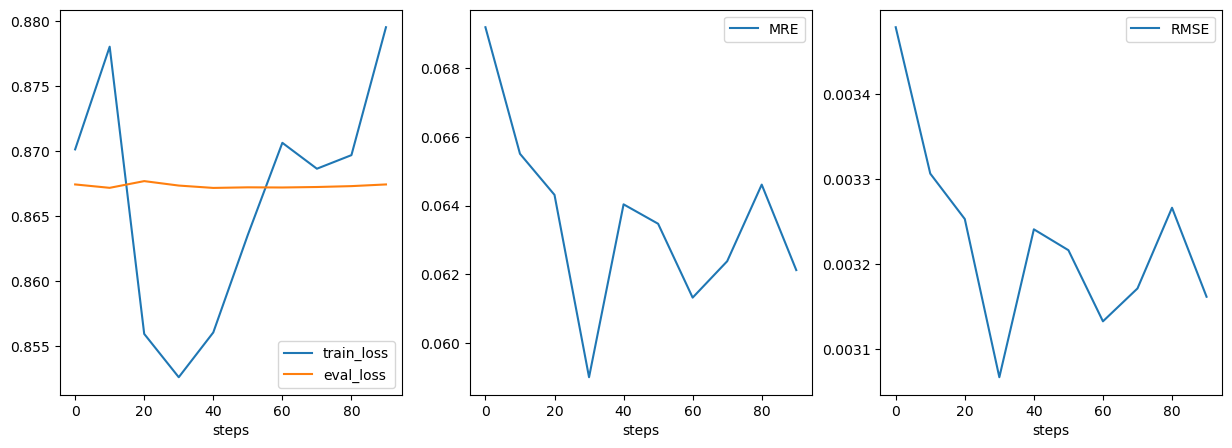

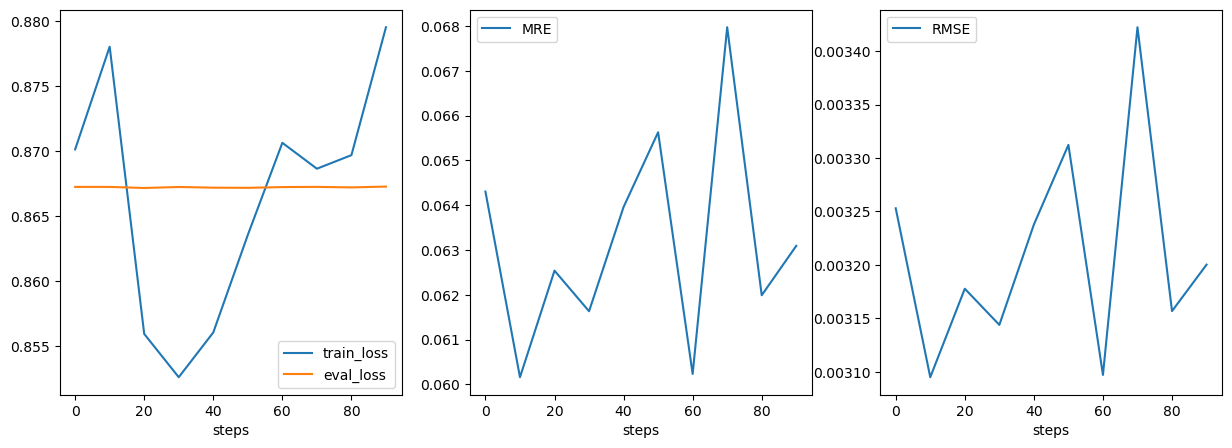

In [14]:
init_model_funcs = {
    ModelType.LSTM.name: init_LSTM_model,
}

model_type = ModelType.LSTM
conf: Config = train_configs[model_type.name]
init_model = init_model_funcs[model_type.name]
model = init_model()
model = model.to(conf.device)
meta_train(model_type, conf, model,
           meta_preporcessed_train_support_loaders,
           meta_preprocessed_train_query_loaders,
           meta_preprocessed_eval_support_loaders,
           meta_preprocessed_eval_query_loaders,
           meta_preprocessed_eval_query_dss,
           compute_evaluate_metrics, to_device)